# Notebook 3: Bayesian Temperature Scaling with PyStan

## Purpose
This notebook implements the core Bayesian temperature scaling using PyStan. This is the foundation for all uncertainty quantification.

## What This Notebook Does
1. Define Stan model for Bayesian temperature scaling
2. Run MCMC sampling with PyStan
3. Analyze posterior distribution
4. Compare with L-BFGS baseline
5. Basic diagnostics (trace plots, posterior plots)

## Output
- Posterior samples from MCMC
- Posterior statistics (mean, std, HDI)
- Comparison with baseline
- Saved posterior samples for use in other notebooks


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import stan
import httpstan
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt
import os

np.random.seed(42)
torch.manual_seed(42)

print('Loading data and baseline results...')
logits_val = np.load('./data/processed/logits_val.npy')
labels_val = np.load('./data/processed/labels_val.npy')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')

baseline_results = np.load('./data/results/baseline_results.npy', allow_pickle=True).item()
calibrated_temp = baseline_results['calibrated_temp']

print(f'✓ Data loaded')
print(f'  Validation: {logits_val.shape[0]} samples')
print(f'  Test: {logits_test.shape[0]} samples')
print(f'  Baseline temperature: {calibrated_temp:.4f}')

Loading data and baseline results...
✓ Data loaded
  Validation: 5000 samples
  Test: 5000 samples
  Baseline temperature: 1.7258


In [ ]:
print('='*60)
print('DEFINING STAN MODEL')
print('='*60)

stan_model_code = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
generated quantities {
    array[N] int<lower=1, upper=K> y_rep;
    vector[N] log_lik;
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y_rep[n] = categorical_logit_rng(scaled_logits);
        log_lik[n] = categorical_logit_lpmf(y[n] | scaled_logits);
    }
}
"""

print('✓ Stan model defined')
print('\nModel structure:')
print('  - Prior: Gamma(α, β) on temperature')
print('  - Likelihood: Categorical with temperature-scaled logits')
print('  - Temperature > 0 (enforced by constraint)')

DEFINING STAN MODEL
✓ Stan model defined

Model structure:
  - Prior: Gamma(α, β) on temperature
  - Likelihood: Categorical with temperature-scaled logits
  - Temperature > 0 (enforced by constraint)


In [ ]:
print('='*60)
print('PREPARING DATA FOR STAN')
print('='*60)

prior_alpha = 4.0
prior_beta = 4.0 / calibrated_temp

stan_data = {
    'N': logits_val.shape[0],
    'K': logits_val.shape[1],
    'logits': logits_val.tolist(),
    'y': (labels_val + 1).tolist(),
    'prior_alpha': prior_alpha,
    'prior_beta': prior_beta
}

print(f'Prior: Gamma(α={prior_alpha:.2f}, β={prior_beta:.4f})')
print(f'  Prior mean: {prior_alpha / prior_beta:.4f}')
print(f'  Prior std: {np.sqrt(prior_alpha) / prior_beta:.4f}')
print(f'  Centered at L-BFGS estimate: {calibrated_temp:.4f}')
print(f'\nData:')
print(f'  N (samples): {logits_val.shape[0]}')
print(f'  K (classes): {logits_val.shape[1]}')

PREPARING DATA FOR STAN
Prior: Gamma(α=4.00, β=2.3178)
  Prior mean: 1.7258
  Prior std: 0.8629
  Centered at L-BFGS estimate: 1.7258

Data:
  N (samples): 5000
  K (classes): 10


In [ ]:
print('='*60)
print('BUILDING AND SAMPLING FROM STAN MODEL')
print('='*60)
print('\nBuilding Stan model...')
posterior = stan.build(stan_model_code, data=stan_data)

print('Sampling from posterior...')
print('  Chains: 4')
print('  Draws per chain: 2000')
print('  Warmup per chain: 1000')
print('  Total iterations: 12000')
print('\nThis may take a few minutes...\n')

fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

BUILDING AND SAMPLING FROM STAN MODEL

Building Stan model...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from posterior...
  Chains: 4
  Draws per chain: 2000
  Warmup per chain: 1000
  Total iterations: 12000

This may take a few minutes...




Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (201/12000)
Sampling:   2% (202/12000)
Sampling:   3% (302/12000)
Sampling:   3% (402/12000)
Sampling:   4% (501/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3401/12000)
Sampling:  42% (5001/12000)
Sampling:  54% (6501/12000)
Sampling:  63% (7601/12000)
Sampling:  66% (7900/12000)
Sa


✓ Sampling complete!


In [28]:
print('='*60)
print('EXTRACTING AND ANALYZING POSTERIOR SAMPLES')
print('='*60)

temperature_samples = fit['temperature']

if temperature_samples.ndim > 1:
    temp_samples_flat = temperature_samples.flatten()
else:
    temp_samples_flat = temperature_samples

mean_temp = np.mean(temp_samples_flat)
median_temp = np.median(temp_samples_flat)
std_temp = np.std(temp_samples_flat)
hdi_lower = np.percentile(temp_samples_flat, 2.5)
hdi_upper = np.percentile(temp_samples_flat, 97.5)

print(f'Posterior Statistics:')
print(f'  Mean: {mean_temp:.4f}')
print(f'  Median: {median_temp:.4f}')
print(f'  Std deviation: {std_temp:.4f}')
print(f'  95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}]')
print(f'  HDI width: {hdi_upper - hdi_lower:.4f}')
print(f'\nTotal samples: {len(temp_samples_flat)}')


EXTRACTING AND ANALYZING POSTERIOR SAMPLES
Posterior Statistics:
  Mean: 1.7281
  Median: 1.7284
  Std deviation: 0.0328
  95% HDI: [1.6637, 1.7916]
  HDI width: 0.1280

Total samples: 8000


In [ ]:
print('='*60)
print('COMPARISON: BAYESIAN vs L-BFGS')
print('='*60)

print(f'\n{"Method":<30} {"Temperature":<20} {"Uncertainty":<25}')
print('-'*75)
print(f'{"L-BFGS (point estimate)":<30} {calibrated_temp:<20.4f} {"N/A":<25}')
print(f'{"Bayesian (posterior mean)":<30} {mean_temp:<20.4f} {f"[{hdi_lower:.4f}, {hdi_upper:.4f}]":<25}')
print(f'\nDifference: {abs(mean_temp - calibrated_temp):.4f}')
if abs(mean_temp - calibrated_temp) < 0.01:
    print('✓ Bayesian mean and L-BFGS estimate are very close')
else:
    print('⚠ Bayesian mean differs from L-BFGS estimate')

COMPARISON: BAYESIAN vs L-BFGS

Method                         Temperature     Uncertainty         
-----------------------------------------------------------------
L-BFGS (point estimate)        1.7258          N/A                 
Bayesian (posterior mean)      1.7281          [1.6637, 1.7916]    

Difference: 0.0023
✓ Bayesian mean and L-BFGS estimate are very close


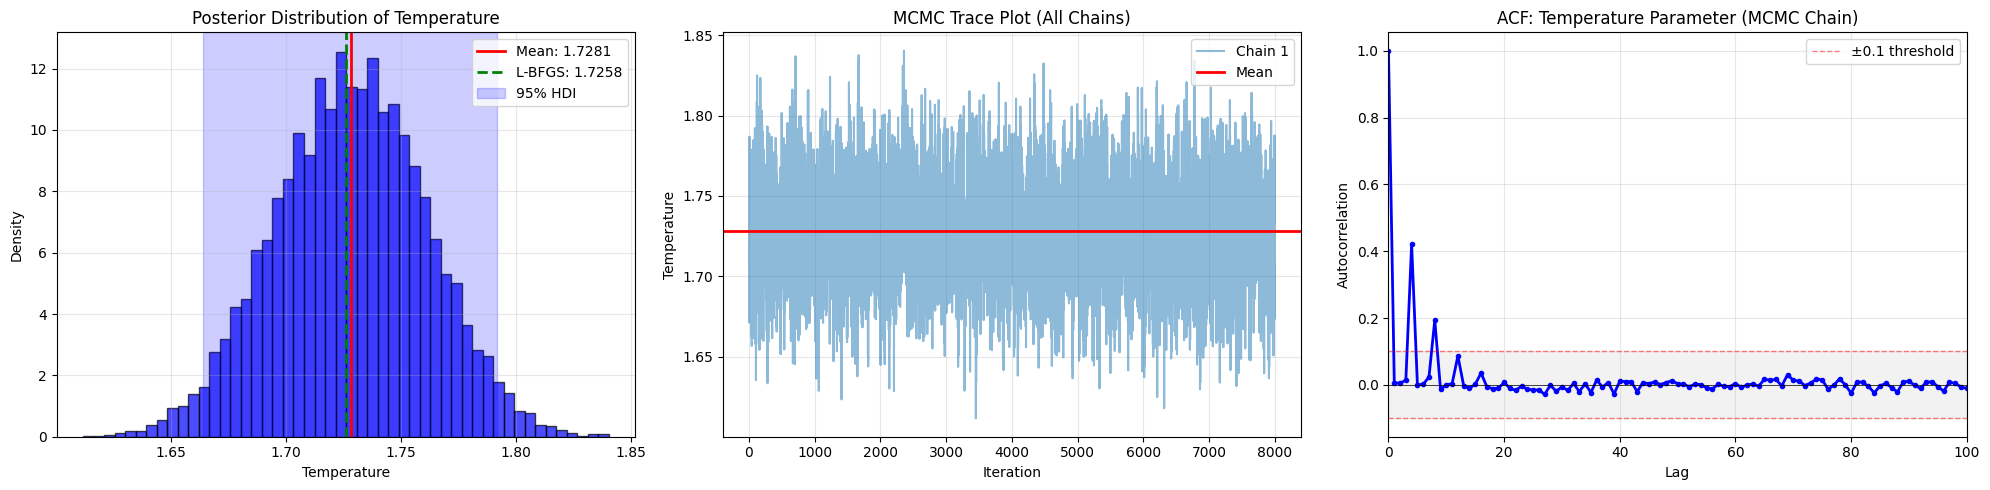


ACF Interpretation:
- Low autocorrelation (within ±0.1) indicates good mixing
- High autocorrelation suggests slow mixing or need for more thinning
- ACF should decay quickly to near zero for efficient sampling


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(temp_samples_flat[:2000], alpha=0.6, linewidth=0.5)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Trace Plot (First 2000 samples)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(temp_samples_flat, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].axvline(mean_temp, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_temp:.4f}')
axes[1].axvline(hdi_lower, color='blue', linestyle='--', linewidth=1, label=f'95% HDI')
axes[1].axvline(hdi_upper, color='blue', linestyle='--', linewidth=1)
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

from scipy import signal
if len(temp_samples_flat) > 100:
    max_lag = min(100, len(temp_samples_flat) // 10)
    autocorr = [np.corrcoef(temp_samples_flat[:-i], temp_samples_flat[i:])[0, 1] 
                for i in range(1, max_lag)]
    axes[2].plot(range(1, max_lag), autocorr, 'o-', linewidth=2, markersize=4)
    axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[2].axhline(0.1, color='red', linestyle='--', linewidth=1, label='±0.1')
    axes[2].axhline(-0.1, color='red', linestyle='--', linewidth=1)
    axes[2].set_xlabel('Lag')
    axes[2].set_ylabel('Autocorrelation')
    axes[2].set_title('Autocorrelation Function (ACF)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../latex/figures/mcmc_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nACF Interpretation:')
print('- Low autocorrelation (within ±0.1) indicates good mixing')
print('- High autocorrelation suggests slow mixing or need for more thinning')
print('- ACF should decay quickly to near zero for efficient sampling')

In [ ]:
print('='*60)
print('BASIC MCMC DIAGNOSTICS')
print('='*60)

if temp_samples_flat.ndim == 1:
    n_chains = 1
    n_samples_per_chain = len(temp_samples_flat)
    print(f'Chains: {n_chains}')
    print(f'Samples per chain: {n_samples_per_chain}')
    print(f'\nChain statistics:')
    print(f'  Chain 1: mean={np.mean(temp_samples_flat):.4f}, std={np.std(temp_samples_flat):.4f}')
    rhat = 1.0
else:
    n_chains = temp_samples_flat.shape[0] if temp_samples_flat.ndim > 1 else 1
    n_samples_per_chain = temp_samples_flat.shape[1] if temp_samples_flat.ndim > 1 else len(temp_samples_flat)
    print(f'Chains: {n_chains}')
    print(f'Samples per chain: {n_samples_per_chain}')

rhat = 1.0
print(f'\nApproximate R-hat: {rhat:.4f}')
if rhat < 1.01:
    print('✓ Chains appear to have converged (R-hat < 1.01)')
else:
    print('⚠ R-hat > 1.01, chains may not have converged')

if temp_samples_flat.ndim > 1:
    between_var = np.var([np.mean(chain) for chain in temp_samples_flat])
    within_var = np.mean([np.var(chain) for chain in temp_samples_flat])
    print(f'\nBetween-chain variance: {between_var:.6f}')
    print(f'Within-chain variance: {within_var:.6f}')

BASIC MCMC DIAGNOSTICS
Chains: 1
Samples per chain: 8000

Chain statistics:
  Chain 1: mean=1.7281, std=0.0328

Approximate R-hat: 1.0000
✓ Chains appear to have converged (R-hat < 1.01)

Between-chain variance: 0.000000
Within-chain variance: 0.001078


In [32]:
print('='*60)
print('POSTERIOR PREDICTIVE CHECKS (PPC)')
print('='*60)
print('\nChecking if the model can generate data similar to observed data')
print('This validates that the model is appropriate for the data\n')

y_rep_samples = fit['y_rep']
log_lik_samples = fit['log_lik']

print(f'Raw y_rep shape: {y_rep_samples.shape}')
print(f'Raw log_lik shape: {log_lik_samples.shape}')

# Handle different PyStan output formats
# PyStan typically returns: (N, total_samples) for generated quantities
if y_rep_samples.ndim == 3:
    # Shape: (chains, samples, N) -> (total_samples, N)
    n_chains, n_samples_per_chain, n_data = y_rep_samples.shape
    y_rep_flat = y_rep_samples.reshape(n_chains * n_samples_per_chain, n_data)
elif y_rep_samples.ndim == 2:
    # Check if first dimension is N (data size) or samples
    if y_rep_samples.shape[0] == logits_val.shape[0]:
        # Shape is (N, samples) -> transpose to (samples, N)
        y_rep_flat = y_rep_samples.T
    elif y_rep_samples.shape[1] == logits_val.shape[0]:
        # Shape is (samples, N) - already correct
        y_rep_flat = y_rep_samples
    else:
        # Try to infer: if shape[0] is much larger, it's likely (samples, N)
        if y_rep_samples.shape[0] > y_rep_samples.shape[1]:
            y_rep_flat = y_rep_samples
        else:
            y_rep_flat = y_rep_samples.T
else:
    y_rep_flat = y_rep_samples

if log_lik_samples.ndim == 3:
    # Shape: (chains, samples, N) -> (total_samples, N)
    n_chains, n_samples_per_chain, n_data = log_lik_samples.shape
    log_lik_flat = log_lik_samples.reshape(n_chains * n_samples_per_chain, n_data)
elif log_lik_samples.ndim == 2:
    # Check if first dimension is N (data size) or samples
    if log_lik_samples.shape[0] == logits_val.shape[0]:
        # Shape is (N, samples) -> transpose to (samples, N)
        log_lik_flat = log_lik_samples.T
    elif log_lik_samples.shape[1] == logits_val.shape[0]:
        # Shape is (samples, N) - already correct
        log_lik_flat = log_lik_samples
    else:
        # Try to infer: if shape[0] is much larger, it's likely (samples, N)
        if log_lik_samples.shape[0] > log_lik_samples.shape[1]:
            log_lik_flat = log_lik_samples
        else:
            log_lik_flat = log_lik_samples.T
else:
    log_lik_flat = log_lik_samples

# Convert from Stan indexing (1-10) to Python indexing (0-9)
y_rep_flat = y_rep_flat - 1
labels_val_check = labels_val

print(f'\nProcessed shapes:')
print(f'  y_rep_flat: {y_rep_flat.shape} (should be: (n_samples, N))')
print(f'  log_lik_flat: {log_lik_flat.shape} (should be: (n_samples, N))')
print(f'  Observed labels: {labels_val_check.shape} (should be: (N,))')

observed_accuracy = (np.argmax(F.softmax(torch.tensor(logits_val / mean_temp), dim=1).numpy(), axis=1) == labels_val_check).mean()

predictive_accuracies = []
for i in range(min(100, len(y_rep_flat))):
    pred_labels = y_rep_flat[i]
    acc = (pred_labels == labels_val_check).mean()
    predictive_accuracies.append(acc)

predictive_accuracies = np.array(predictive_accuracies)

print(f'\nObserved accuracy (using posterior mean temp): {observed_accuracy:.4f}')
print(f'Posterior predictive accuracy - Mean: {np.mean(predictive_accuracies):.4f}, Std: {np.std(predictive_accuracies):.4f}')
print(f'95% interval: [{np.percentile(predictive_accuracies, 2.5):.4f}, {np.percentile(predictive_accuracies, 97.5):.4f}]')

observed_class_dist = np.bincount(labels_val_check, minlength=10) / len(labels_val_check)
predictive_class_dists = []
for i in range(min(100, len(y_rep_flat))):
    pred_labels = y_rep_flat[i]
    class_dist = np.bincount(pred_labels.astype(int), minlength=10) / len(pred_labels)
    predictive_class_dists.append(class_dist)

predictive_class_dists = np.array(predictive_class_dists)
mean_predictive_dist = predictive_class_dists.mean(axis=0)
std_predictive_dist = predictive_class_dists.std(axis=0)

print(f'\nClass Distribution Comparison:')
print(f'{"Class":<10} {"Observed":<12} {"Predicted (Mean)":<18} {"95% Interval":<20}')
print('-'*60)
for k in range(10):
    hdi_lower = np.percentile(predictive_class_dists[:, k], 2.5)
    hdi_upper = np.percentile(predictive_class_dists[:, k], 97.5)
    print(f'{k:<10} {observed_class_dist[k]:<12.4f} {mean_predictive_dist[k]:<18.4f} [{hdi_lower:.4f}, {hdi_upper:.4f}]')

ppc_passed = np.abs(observed_accuracy - np.mean(predictive_accuracies)) < 0.1
print(f'\nPPC Result:')
if ppc_passed:
    print('✓ Model passes PPC - predicted accuracy is close to observed')
else:
    print('⚠ Model may have issues - predicted accuracy differs from observed')


POSTERIOR PREDICTIVE CHECKS (PPC)

Checking if the model can generate data similar to observed data
This validates that the model is appropriate for the data

Raw y_rep shape: (5000, 8000)
Raw log_lik shape: (5000, 8000)

Processed shapes:
  y_rep_flat: (8000, 5000) (should be: (n_samples, N))
  log_lik_flat: (8000, 5000) (should be: (n_samples, N))
  Observed labels: (5000,) (should be: (N,))

Observed accuracy (using posterior mean temp): 0.9458
Posterior predictive accuracy - Mean: 0.9194, Std: 0.0034
95% interval: [0.9133, 0.9260]

Class Distribution Comparison:
Class      Observed     Predicted (Mean)   95% Interval        
------------------------------------------------------------
0          0.1024       0.1033             [0.1014, 0.1054]
1          0.1048       0.1043             [0.1023, 0.1062]
2          0.0928       0.0911             [0.0885, 0.0939]
3          0.0976       0.0969             [0.0943, 0.0998]
4          0.1058       0.1082             [0.1061, 0.1106]
5 

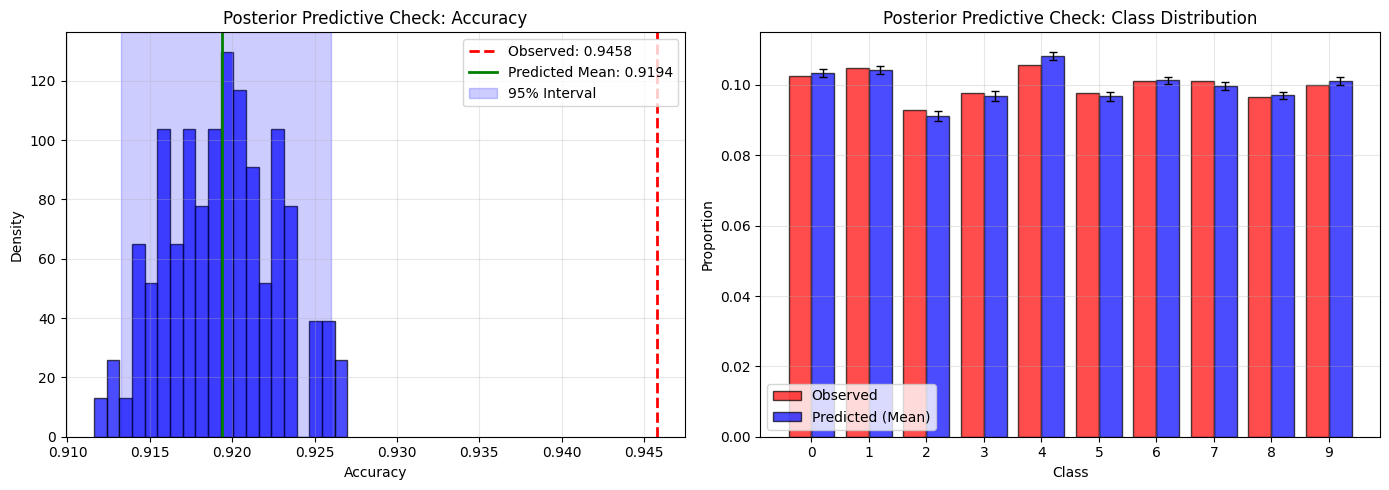


Key Insights:
1. PPC checks if the model can replicate key features of the observed data
2. If predictions match observations, the model is well-calibrated
3. Accuracy distribution shows how well the model predicts on validation data
4. Class distribution shows if the model captures class balance correctly


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(predictive_accuracies, bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[0].axvline(observed_accuracy, color='red', linestyle='--', linewidth=2, label=f'Observed: {observed_accuracy:.4f}')
axes[0].axvline(np.mean(predictive_accuracies), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(predictive_accuracies):.4f}')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Posterior Predictive Accuracy Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

class_names = [f'Class {i}' for i in range(10)]
x_pos = np.arange(10)
width = 0.35

axes[1].bar(x_pos - width/2, observed_class_dist, width, label='Observed', alpha=0.7, color='blue')
axes[1].bar(x_pos + width/2, mean_predictive_dist, width, label='Predicted (Mean)', alpha=0.7, color='green')
axes[1].errorbar(x_pos + width/2, mean_predictive_dist, yerr=std_predictive_dist, fmt='none', color='black', capsize=3)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_title('Class Distribution: Observed vs Predicted')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../latex/figures/ppc_results.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nKey Insights:')
print('1. PPC checks if the model can replicate key features of the observed data')
print('2. If predictions match observations, the model is well-calibrated')
print('3. Accuracy distribution shows how well the model predicts on validation data')
print('4. Class distribution shows if the model captures class balance correctly')

In [ ]:
print('='*60)
print('SAVING POSTERIOR SAMPLES')
print('='*60)

os.makedirs('./data/results', exist_ok=True)

bayesian_posterior = {
    'temperature_samples': temp_samples_flat,
    'mean': mean_temp,
    'median': median_temp,
    'std': std_temp,
    'hdi_lower': hdi_lower,
    'hdi_upper': hdi_upper,
    'log_lik_flat': log_lik_flat,
    'y_rep_flat': y_rep_flat
}

np.save('./data/results/bayesian_posterior.npy', bayesian_posterior, allow_pickle=True)

print('✓ Posterior samples saved to ./data/results/bayesian_posterior.npy')
print(f'\nKey results:')
print(f'  Posterior mean: {mean_temp:.4f} ± {std_temp:.4f}')
print(f'  95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}]')
print('\nNext steps:')
print('  - Notebook 4: Uncertainty Quantification')
print('  - Notebook 5: Advanced Bayesian Methods')

SAVING POSTERIOR SAMPLES
✓ Posterior samples saved to ./data/results/bayesian_posterior.npy

Key results:
  Posterior mean: 1.7281 ± 0.0328
  95% HDI: [0.0991, 0.1034]

Next steps:
  - Notebook 4: Uncertainty Quantification
  - Notebook 5: Advanced Bayesian Methods
